# Import library

In [2]:
import numpy as np
import pandas as pd
import pyapep as pa
import matplotlib.pyplot as plt
import pyiast

# Isotherm Data (HKUST1 vs CH4/N2)

## Dummy data for fitting

Text(0.5, 1.0, 'N2 dummy')

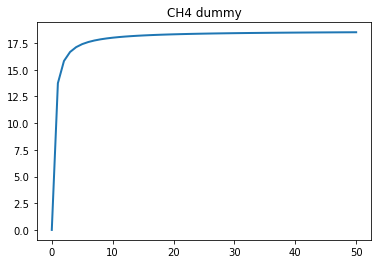

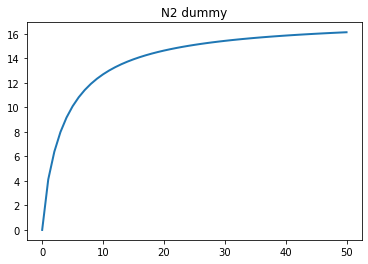

In [3]:
par_ch4 = [18.6374222,   2.80157235] # Based on mol/kg vs bar
par_n2 = [0.79395206, 16.51415926, 11.9393412,   0.25786263] # Based on mol/kg vs bar

dH_list = [16.3725284,11.67565] ## kJ
T_ref_list = [180,180]  ## K

def Lang(p_in,par):
    qtmp = par[0] * par[1]*p_in/(1+par[1]*p_in)
    return qtmp

def DSLa(p_in,par):
    qtmp1 = par[0]*par[2]*p_in/(1+par[2]*p_in)
    qtmp2 = par[1]*par[3]*p_in/(1+par[3]*p_in)
    qtmp_return = qtmp1 + qtmp2
    return qtmp_return
    
        

## CH4 Case ##
p_test = np.linspace(0,50, 51)
qch4_test = Lang(p_test,par_ch4)
di_ch4 = {'p':p_test,'q':qch4_test}
df_ch4 = pd.DataFrame(di_ch4)

plt.figure()
plt.plot(p_test,qch4_test,linewidth = 2)
plt.title('CH4 dummy')


## N2 Case ##
p_test = np.linspace(0,50, 51)
qn2_test = DSLa(p_test,par_n2)
di_n2 = {'p':p_test,'q':qn2_test}
df_n2 = pd.DataFrame(di_n2)

plt.figure()
plt.plot(p_test,qn2_test,linewidth = 2)
plt.title('N2 dummy')

## Fitting with pyiast

In [4]:
iso0 = pyiast.ModelIsotherm(df_ch4,
                            loading_key='q',pressure_key = 'p',
                            model= 'Langmuir', 
                            param_guess = {'M': par_ch4[0],'K':par_ch4[1]})
print(iso0.params)

iso1 = pyiast.ModelIsotherm(df_n2,
                            loading_key='q',pressure_key = 'p',
                            model= 'DSLangmuir', 
                            param_guess = {'M1': par_n2[0],
                                           'M2': par_n2[1],
                                           'K1':par_n2[2],
                                           'K2':par_n2[3]})
print(iso1.params)
iso_pyiast = [iso0, iso1]


{'M': 18.6374222, 'K': 2.80157235}
{'M1': 0.79395206, 'K1': 11.9393412, 'M2': 16.51415926, 'K2': 0.25786263}


# Test Storage Tank Model

In [5]:
### Conditions ###

# %% Feed conditions
# Inlet conditions ?
feed_composition = [0.995,0.005]
T_inlet = 300 # K

# %% Heat capacity info
# Heat related properties (methane; nitrogen) + (zeolite)
Cp_g = np.array([40.63,29.22])  # Gas heat capacity: J/mol/K
Cp_s = 948                      # Solid heat capacity: J/kg/K

x_gas = [0.995,0.005]
q_solid = [0.0,0.0]
T_current = [298]
initial_variables = x_gas + q_solid + T_current


In [6]:
Result_test = pa.storage_tank(feed_composition,iso_pyiast,dH_list,T_ref_list,
                              initial_variables,P_in=5, T_in = T_inlet)
Perf_test = pa.Massbal_interation(Result_test.x[0:2], Result_test.x[2],
                                  feed_composition,iso_pyiast,dH_list,T_ref_list,
                                  initial_variables,P_in=5, T_in = T_inlet)
print(Perf_test)

SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
(9913.452568330596, array([1.7445343 , 0.00854696]), 0, array([ True,  True]))


# For different pressure and temperature

## Import Feed Conditions

[153.15  171.68  188.339 202.061 213.797 224.099 233.775 242.867 251.183
 258.851 265.971 272.618 278.854 284.73  290.288 295.56  300.574 305.355
 309.925 314.302]
[ 1.06  1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5
  7.    7.5   8.    8.5   9.    9.5  10.   10.5 ]


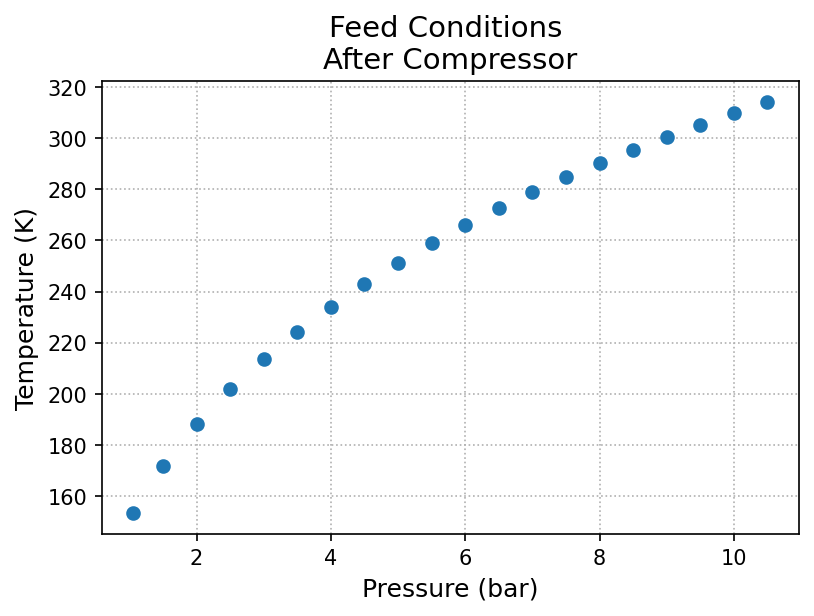

In [23]:
FC = pd.read_excel('Feed_conditions.xlsx')
Tfeed_arr = FC['T(K)'].to_numpy()
Pfeed_arr = FC['P(bar)'].to_numpy()
print(Tfeed_arr)
print(Pfeed_arr)

## Graph ##
plt.figure(dpi =150)
plt.plot(Pfeed_arr,Tfeed_arr, 'o')
plt.ylabel('Temperature (K)',fontsize = 12)
plt.xlabel('Pressure (bar)',fontsize = 12)
plt.title('Feed Conditions \nAfter Compressor',fontsize = 14)
plt.grid(linestyle = ':')

## Run Storage Model

In [8]:
del_M_list = []
T_fin_list = []
Design_spec = {'A': 3.1416, 'L':5,'rho_s':1000, 'epsi':0.4}
for T_ff, P_ff in zip(Tfeed_arr, Pfeed_arr):
    Result_tmp = pa.storage_tank(feed_composition,iso_pyiast, dH_list,T_ref_list,
                                initial_variables, P_in = P_ff, T_in = T_ff,
                                Design=Design_spec)
    Perf_tmp = pa.Massbal_interation(Result_tmp.x[0:2], Result_tmp.x[2],
                                     feed_composition,iso_pyiast, dH_list,T_ref_list,
                                     initial_variables, P_in = P_ff, T_in = T_ff,
                                    Design=Design_spec)
    del_M_list.append(Perf_tmp[0])
    T_fin_list.append(Result_tmp.x[2])

C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
Differential Evolution METHOD IS USED !!!
Differential Evolution IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:363: RuntimeWarning: invalid value encountered in log
  return self.params["M1"] * np.log(
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:365: RuntimeWarning: invalid value encountered in log
  self.params["M2"] * np.log(


SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!


## Graph (Storage)

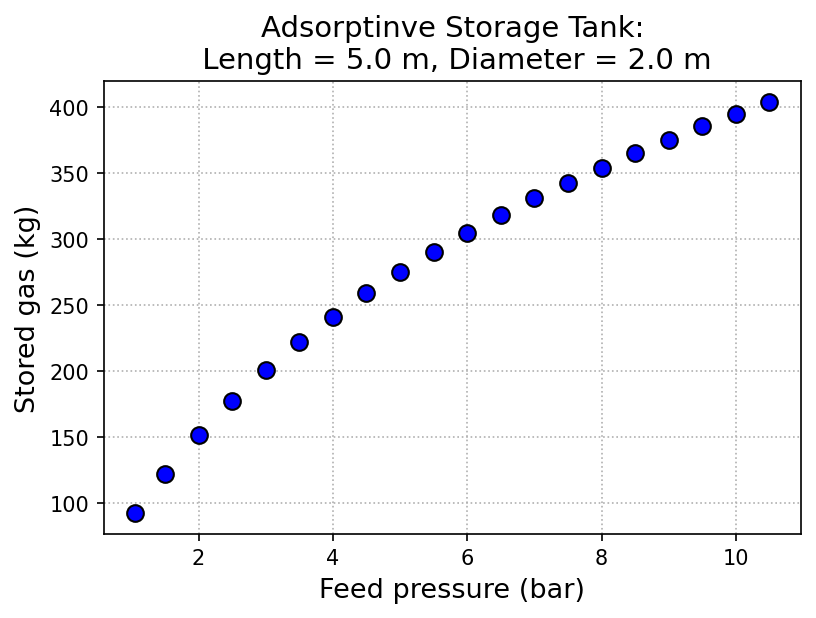

In [9]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg,
         'o', color = 'k',markersize = 8, mfc = 'b')
plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Stored gas (kg)', fontsize = 13)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

## Graph (Temperature)

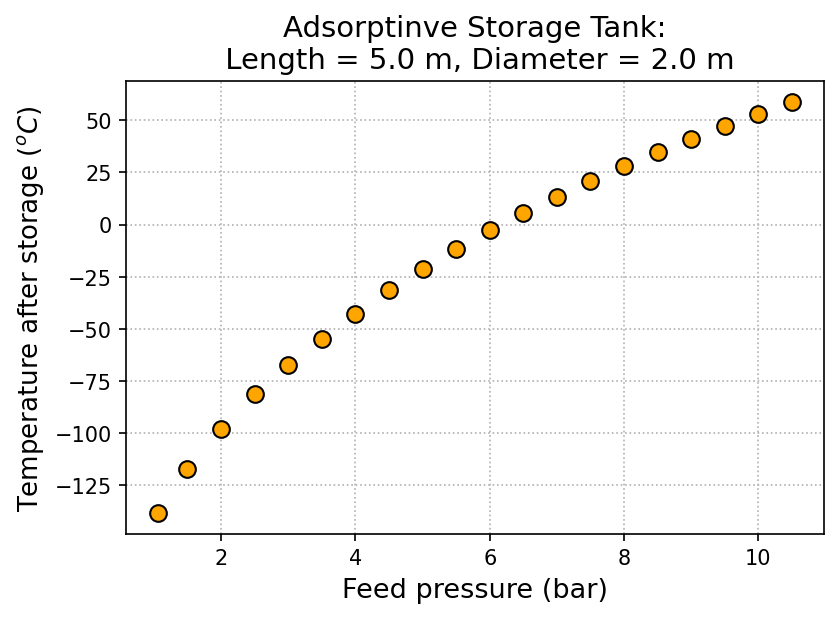

In [10]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, np.array(T_fin_list) + Tfeed_arr - 298.15,
         'o', color = 'k',markersize = 8,mfc = 'orange')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Temperature after storage ($^{o}C$)', fontsize = 12.5)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

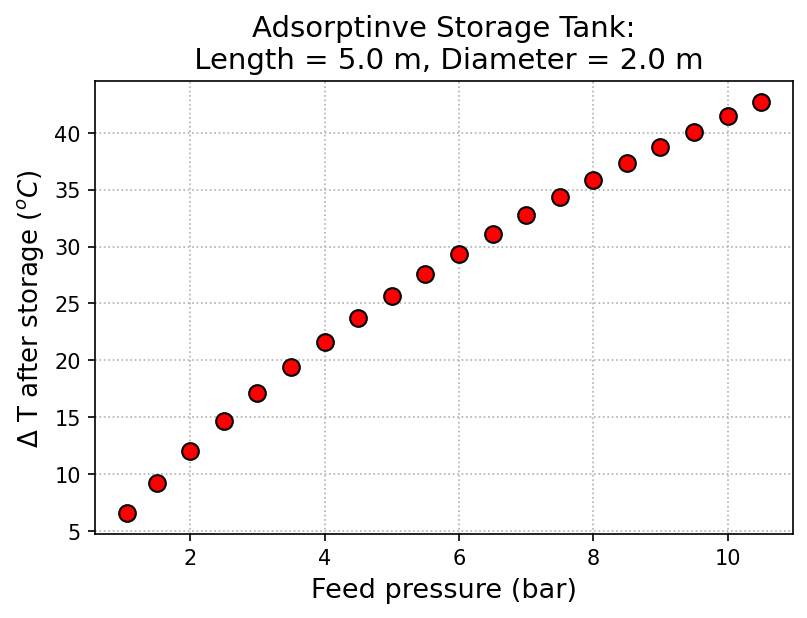

In [11]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

# Surrogate Model

In [12]:
import scipy.optimize as optim

## Storage

In [13]:
def fn_guess(par,P):
    #T_return = par[0]*(par[1]*P)/(1+ par[1]*P) + par[2]*(par[3]*P)/(1+ par[3]*P)
    del_m_return = par[0]*(par[1]*P**par[2])/(1+ par[1]*P**par[2])
    return del_m_return 

def err_storage(par):
    #del_m_tmp = par[0]*par[1]*Pfeed_arr/(1+ par[1]*Pfeed_arr)
    del_m_tmp = fn_guess(par,Pfeed_arr)
    err = del_m_tmp - del_M_kg
    err_sq_sum = np.sum(err**2)
    return err_sq_sum
#es_opt = optim.shgo(err_storage, bounds=[[100,1000],[0,50]])
res_opt = optim.minimize(err_storage, x0 = [100, 10,2],
                        method = 'Nelder-Mead')
print(res_opt)
psol = res_opt.x
P_ran = np.linspace(1,51,101)
del_M_pred = fn_guess(psol, P_ran)

 final_simplex: (array([[8.05959009e+02, 1.24309289e-01, 8.87491580e-01],
       [8.05958952e+02, 1.24309295e-01, 8.87491616e-01],
       [8.05959002e+02, 1.24309287e-01, 8.87491596e-01],
       [8.05959002e+02, 1.24309286e-01, 8.87491599e-01]]), array([8.27515447, 8.27515447, 8.27515447, 8.27515447]))
           fun: 8.275154473243397
       message: 'Optimization terminated successfully.'
          nfev: 414
           nit: 231
        status: 0
       success: True
             x: array([8.05959009e+02, 1.24309289e-01, 8.87491580e-01])


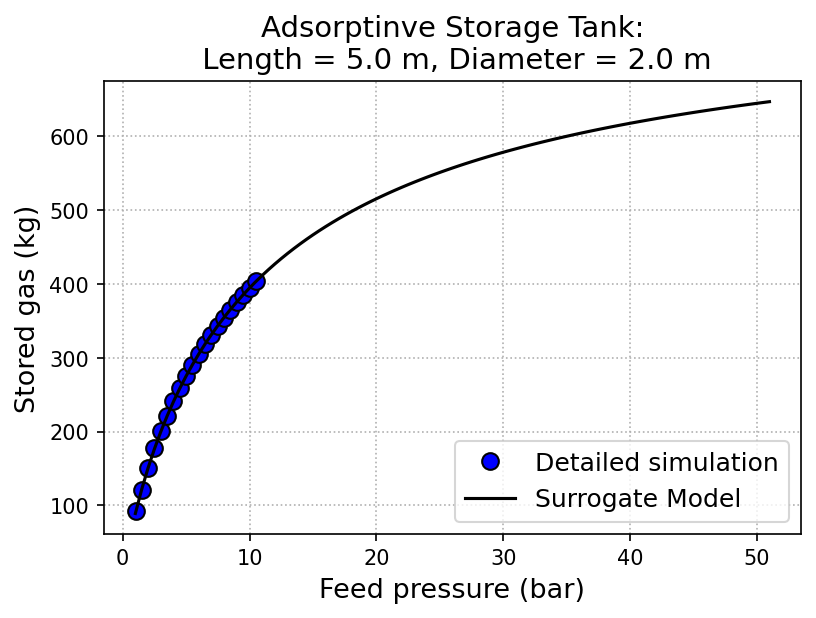

In [14]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg,
         'o', color = 'k',markersize = 8, mfc = 'b',
        label = 'Detailed simulation')
plt.plot(P_ran,del_M_pred,'k',label = 'Surrogate Model')


plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Stored gas (kg)', fontsize = 13)

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

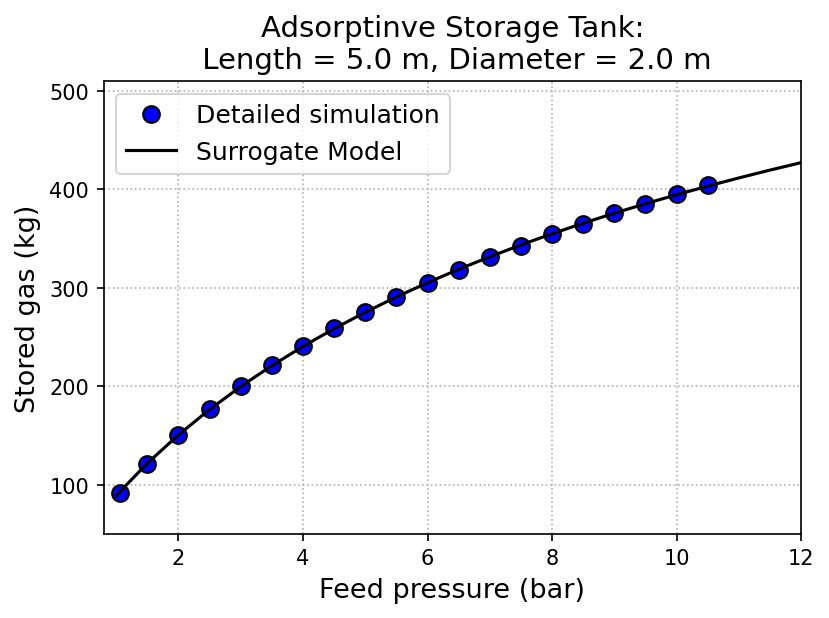

In [15]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg,
         'o', color = 'k',markersize = 8, mfc = 'b',
        label = 'Detailed simulation')
plt.plot(P_ran,del_M_pred,'k',label = 'Surrogate Model')


plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Stored gas (kg)', fontsize = 13)

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)
plt.xlim(0.8, 12)
plt.ylim(50, 510)
plt.grid(linestyle = ':')

## Temperture Shift

In [16]:
def fn_guess(par,P):
    #T_return = par[0]*(par[1]*P)/(1+ par[1]*P) + par[2]*(par[3]*P)/(1+ par[3]*P)
    T_return = par[0]*(par[1]*P**par[2])/(1+ par[1]*P**par[2])
    return T_return
    
def err_tempshif(par):
    #del_m_tmp = par[0]*(2*par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)/(1+ par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)
    #del_m_tmp = par[0]*(2*par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)/(1+ par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)
    #del_m_tmp = par[0]*(par[1]*Pfeed_arr)/(1+ par[1]*Pfeed_arr) + par[2]*(par[3]*Pfeed_arr)/(1+ par[3]*Pfeed_arr)
    T_tmp = fn_guess(par,Pfeed_arr)
    err = T_tmp - np.array(T_fin_list)
    err_sq_sum = np.sum(err**2)
    return err_sq_sum
#res_opt = optim.shgo(err_storage, bounds=[[20,200],[0,10],[0,20],[0,100]])
res_opt = optim.minimize(err_tempshif, x0 = [113.8, 0.05, 5],
                        method = 'Nelder-Mead')
print(res_opt)
psol = res_opt.x
P_ran = np.linspace(0,51,111)
T_fin_pred = fn_guess(psol, P_ran)

 final_simplex: (array([[1.07147887e+02, 6.31411514e-02, 9.98720824e-01],
       [1.07147801e+02, 6.31411936e-02, 9.98721089e-01],
       [1.07147835e+02, 6.31411735e-02, 9.98721021e-01],
       [1.07147875e+02, 6.31411553e-02, 9.98720857e-01]]), array([0.07549657, 0.07549657, 0.07549657, 0.07549657]))
           fun: 0.07549657288221974
       message: 'Optimization terminated successfully.'
          nfev: 419
           nit: 235
        status: 0
       success: True
             x: array([1.07147887e+02, 6.31411514e-02, 9.98720824e-01])


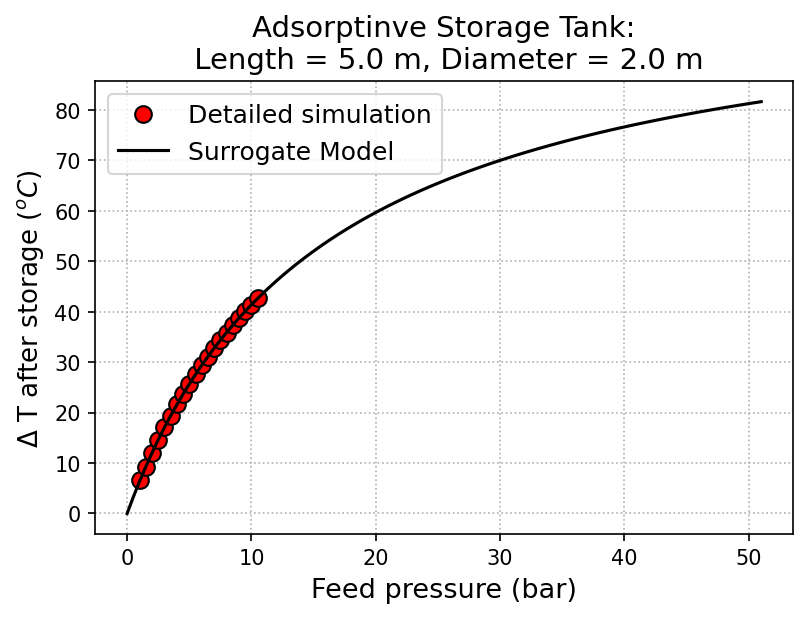

In [17]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r',
        label = 'Detailed simulation')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

plt.plot(P_ran,T_fin_pred,'k',label = 'Surrogate Model')

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

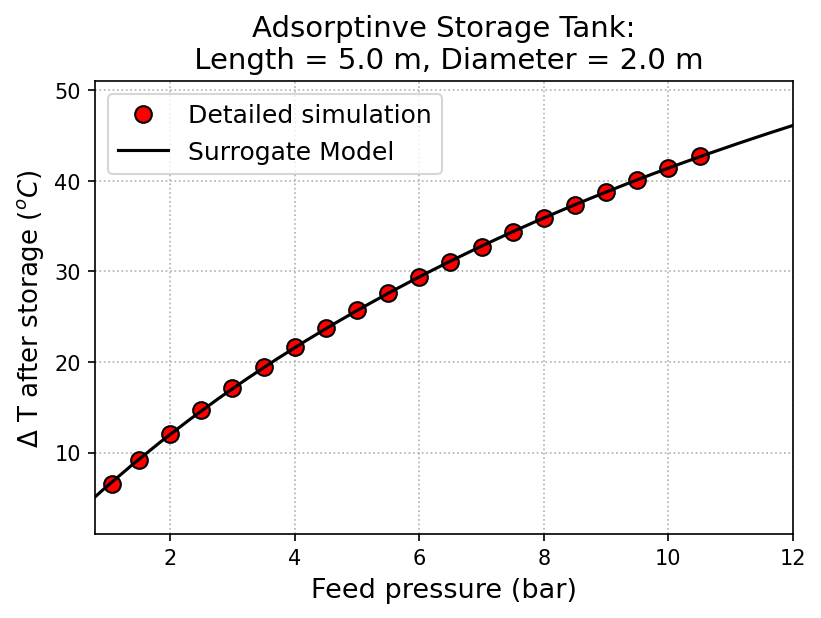

In [18]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r',
        label = 'Detailed simulation')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

plt.plot(P_ran,T_fin_pred,'k',label = 'Surrogate Model')

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.xlim(0.8,12)
plt.ylim(1, 51)

plt.grid(linestyle = ':')